In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import svm
from sklearn import neural_network
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt
import scipy.stats as sc

In [3]:
# Import the entire dataset
dataset = pd.read_excel('Dataset',sheetname=None)
data = dataset['Supplemental Data - County']
data = data.rename(columns={'FIPS Code':'FIPS','County Name':'County'})

In [4]:
# Merge all the excel worksheets into one DataFrame
for sheet in dataset:
    if 'FIPS' in dataset[sheet]:
        data = pd.merge(dataset[sheet],data,on=['FIPS','State','County']) 
data = data.set_index('FIPS')

In [5]:
# Drop columns that have many NaN values, then rows with any remaining NaN values
data.dropna(axis=1,thresh=(len(data)-100),inplace=True)
data.dropna(axis=0,inplace=True)
data.shape

(2935, 167)

In [6]:
# DataFrame of only the numeric features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_data = data.select_dtypes(include=numerics)
numeric_data.shape

(2935, 161)

In [7]:
# Pearson correlation between the SUPERC07 column and the SUPERC12 column
sc.pearsonr(numeric_data['SUPERC12'],numeric_data['SUPERC07'])

(0.95903170360412715, 0.0)

In [8]:
# Pick a target column, save it, and delete it from the data along with other dependent columns
features = ['SUPERC12','SUPERC07','PCH_SUPERC_07_12','SUPERCPTH07','SUPERCPTH12','PCH_SUPERCPTH_07_12']
try:
    target = numeric_data[features[0]]
except:
    pass
for feature in features:
    try:
        del numeric_data[feature]
    except:
        continue
numeric_data.shape

(2935, 157)

In [10]:
# Normalized columns to Z-scores
norm_data = pd.DataFrame(sc.zscore(numeric_data),index=numeric_data.index,columns=numeric_data.columns)
norm_data.dropna(axis=1,inplace=True)
norm_target = sc.zscore(target)
norm_data.shape

(2935, 154)

In [12]:
# Select the k most predictive features of the target column
k_data = SelectKBest(f_regression,k = 3).fit(numeric_data,target)
k_columns = k_data.get_support(True)
numeric_data.columns[k_columns]

Index([u'LACCESS_POP10', u'LACCESS_CHILD10', u'CONVS12'], dtype='object')

In [13]:
# PCA for the k most predictive features
pca = PCA(n_components=1)
reduct_data = pca.fit_transform(numeric_data[numeric_data.columns[k_columns]])
pca.explained_variance_ratio_

array([ 0.99912985])

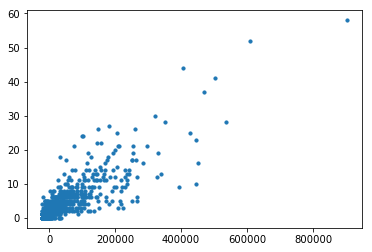

In [14]:
# scatter plot of the target column as a dependency of PC1
plt.scatter(reduct_data,target,s=10)
plt.show()

In [15]:
# Pearson correlation between PC1 and the target column
sc.pearsonr(pd.DataFrame(reduct_data)[0],target)

(0.87128897941314953, 0.0)

In [16]:
# Divide the data into a training-testing subsets
seed = 43
train_size = 0.7
X_train, X_test, y_train, y_test = \
train_test_split(numeric_data, target, train_size = train_size, random_state = seed)

In [18]:
# Linear regression model
%time regr = linear_model.LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

# The coefficients
print 'Coefficients:', regr.coef_

# The intercept
print 'intercept:', regr.intercept_

# The mean squared error
print ("Mean squared error: %.5f" %np.mean((y_pred - y_test) ** 2))

# Explained variance score: 1 is perfect prediction
print ('Variance score: %.2f' %regr.score(X_test, y_test))

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 16.7 ms
Coefficients: [  1.60216461e-02  -8.05989936e-03  -5.19581707e-03  -1.05705853e-01
   5.03410391e-01   4.57400114e-03   3.67980566e-02   1.67742950e-03
   1.46509019e-03  -3.54042172e-01  -5.36031050e-02  -9.97419016e-04
   3.59513859e-02   6.49932886e-03   6.92704495e-02  -3.08993768e-02
   8.53711817e-03  -7.76792770e-02   5.12160823e-02   9.44575606e-01
  -1.29699811e+00   4.02898938e-03  -6.21672509e-03  -4.48680400e-04
  -2.62789330e-03  -7.46164718e-02  -1.23622217e-02   3.09674144e-01
  -2.94521703e-02  -8.81142156e-04  -4.91510738e-02  -7.66273892e-02
  -7.84238630e-02  -7.92604854e-02  -5.30668696e-02  -8.41668847e-02
   8.04038824e-01  -1.49740469e-03   2.58169517e-02   5.85192664e-03
  -3.39635255e-02   6.60054798e-02   3.73774997e-02  -4.18384329e-02
   1.29027790e-02  -6.01516427e-03   2.48815113e+00   3.30492656e-02
  -3.25747756e-02  -4.17135240e-02   2.35468144e-01   1.65802846e-03
  -1.64507580e-05   1.941

In [19]:
# SVM regression model
%time svr = svm.SVR().fit(X_train, y_train)
y_pred = svr.predict(X_test)

# Explained variance score: 1 is perfect prediction
print ('Variance score: %.2f' %svr.score(X_test, y_test))

CPU times: user 972 ms, sys: 84 ms, total: 1.06 s
Wall time: 1.22 s
Variance score: -0.05


In [20]:
# Neural network regression model
%time mlp = neural_network.MLPRegressor().fit(X_train, y_train)
y_pred = mlp.predict(X_test)

# Explained variance score: 1 is perfect prediction
print ('Variance score: %.2f' %mlp.score(X_test, y_test))

CPU times: user 68 ms, sys: 4 ms, total: 72 ms
Wall time: 128 ms
Variance score: -4504316.86


In [21]:
# XGBoost regression model
%time xgb_model = xgb.XGBRegressor().fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print ('Variance score: %.2f' %xgb_model.score(X_test, y_test))

CPU times: user 796 ms, sys: 0 ns, total: 796 ms
Wall time: 883 ms
Variance score: 0.89


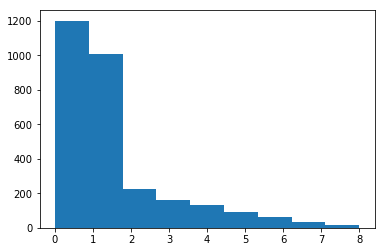

In [22]:
# Conversion of the problem to a classification problem
target_bin = [None]*target.count()
for ind,val in enumerate(target):
    if val == 0:
        target_bin[ind] = 0
    elif val == 1:
        target_bin[ind] = 1
    elif val == 2:
        target_bin[ind] = 2
    elif val == 3:
        target_bin[ind] = 3
    elif val <= 5:
        target_bin[ind] = 4
    elif val <= 8:
        target_bin[ind] = 5
    elif val <= 13:
        target_bin[ind] = 6
    elif val <= 21:
        target_bin[ind] = 7
    else:
        target_bin[ind] = 8

plt.hist(target_bin,bins=9)
plt.show()

In [23]:
# Divide the data into a training-testing subsets
seed = 43
train_size = 0.7
X_train, X_test, y_train, y_test = \
train_test_split(numeric_data, target_bin, train_size = train_size, random_state = seed)

In [25]:
# Gaussian Naive Bayes classification model
%time gnb = GaussianNB().fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print ('Accuracy score: %.2f' %gnb.score(X_test, y_test))

CPU times: user 24 ms, sys: 8 ms, total: 32 ms
Wall time: 77.5 ms
Accuracy score: 0.53


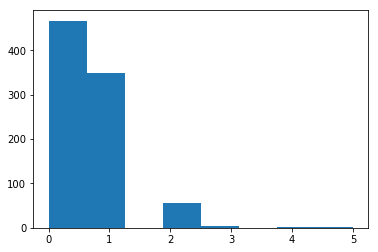

In [26]:
a = np.abs(y_test - y_pred)
plt.hist(a,bins=8)
plt.show()

In [27]:
# Decision tree classification model
%time dtc = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_pred = dtc.predict(X_test)

print ('Accuracy score: %.2f' %dtc.score(X_test, y_test))

CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 229 ms
Accuracy score: 0.63


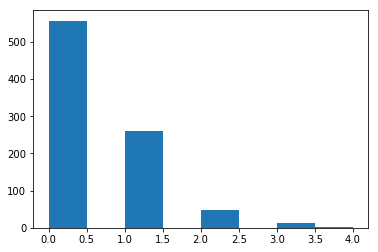

In [28]:
a = np.abs(y_test - y_pred)
plt.hist(a,bins=8)
plt.show()

In [29]:
# Random forest classification model
%time rfc = RandomForestClassifier().fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print ('Accuracy score: %.2f' %rfc.score(X_test, y_test))

CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 148 ms
Accuracy score: 0.69


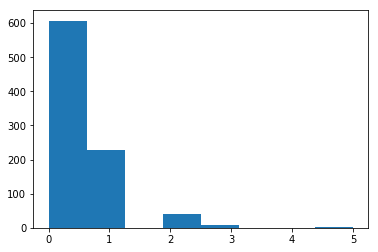

In [30]:
a = np.abs(y_test - y_pred)
plt.hist(a,bins=8)
plt.show()

# Metrics table
|Algorithm           |Running time|Accuracy/Explained variance|
|-------------------:|-----------:|--------------------------:|
|Linear regression   |16.7 ms     |0.89                       |
|SVM                 |1.15 s      |-0.05                      |
|Neural network      |223 ms      |-73075.91                  |
|XGBoost             |829 ms      |0.89                       |
|Gaussian Naive Bayes|21.7 ms     |0.53                       |
|Decision tree       |249 ms      |0.62                       |
|Random forest       |144 ms      |0.69                       |
